<div style="background-color:#2d8bba; color:white; font-weight:bold; padding:15px; border-radius: 5px; font-size: 14px;">
    <h2 style="margin:0;">ESTUDIO DE LOS INDICADORES IRH (RENTABILIDAD HOTELERA), por Borja Ramos</h2>
</div>

<div style="background-color:#2d8bba; color:white; font-weight:normal; padding:10px; border-radius: 5px;">
Glosario sobre el dataset:<br>
· RevPAR: Ingresos por habitación disponible. Se calcula dividiendo los ingresos totales por habitaciones por el número de habitaciones disponibles.<br>
· ADR: Tarifa media diaria. Se calcula dividiendo los ingresos totales por habitaciones por el número de habitaciones ocupadas.<br>
Como vemos, se añade en el dataset la tasa de variación de ambos valores
</div>

<div style="background-color:#2d8bba; color:white; font-weight:bold; padding:10px; border-radius: 5px;">
1 - LIMPIEZA DE DATOS / ANÁLISIS HISTÓRICO
</div>

In [1]:
### importamos las librerías de python necesarias. más tarde necesitaremos otras para las predicciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [119]:
### cargamos el dataset que está en formato excel
df = pd.read_excel('../data/ind_rentabilidad_hotelera_ccaa.xlsx', engine='openpyxl')

In [3]:
### inspeccionamos las primeras columnas, para ver la estructura
df.head()

,AÑO,MES,CCAA,INDICADOR_ADR,TASA_VARIACION_ADR,INDICADOR_RVPAR,TASA_VARIACION_RVPAR
0,2008,1,Región de Murcia,64.63,0.0,22.76,0.0
1,2008,2,Región de Murcia,62.72,0.0,30.23,0.0
2,2008,3,Región de Murcia,63.76,0.0,32.53,0.0
3,2008,4,Región de Murcia,63.42,0.0,29.43,0.0
4,2008,5,Región de Murcia,62.95,0.0,31.59,0.0


In [4]:
### vamos a ver qué tipo de datos tienen las columnas
df.dtypes

AÑO                       int64
MES                       int64
CCAA                     object
INDICADOR_ADR           float64
TASA_VARIACION_ADR      float64
INDICADOR_RVPAR         float64
TASA_VARIACION_RVPAR    float64
dtype: object

In [121]:
### puesto que el dataset ya se recogió filtrado para la Comunidad de Murcia, no hace falta la columna 'CCAA' y la quitamos
df = df.drop(columns=['CCAA']) # o lo que es lo mismo df = df.drop('CCAA', axis=1)

In [122]:
### vamos a averiguar si hay valores nulos
df.isnull().sum()

AÑO                     0
MES                     0
INDICADOR_ADR           0
TASA_VARIACION_ADR      0
INDICADOR_RVPAR         0
TASA_VARIACION_RVPAR    0
dtype: int64

In [123]:
### vamos a ver si faltan datos en las fechas
# vemos si faltan meses
meses_x_año = df.groupby('AÑO')['MES'].nunique()

print(meses_x_año)


AÑO
2008    12
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
2017    12
2018    12
2019    12
2020    12
2021    12
2022    12
2023    11
Name: MES, dtype: int64


In [ ]:
# efectivamente no falta ninguno, la muestra es hasta diciembre de 2023

In [124]:
### vamos a hacer como en otros notebooks anteriores, pasar año y mes a una sola columna y pasarlo al index para

# queremos que las columnas MES y AÑO sean de tipo string y que MES tenga dos dígitos
df['MES'] = df['MES'].astype(str).str.zfill(2)
df['AÑO'] = df['AÑO'].astype(str)

# creamos la nueva columna FECHA usando las columnas MES y AÑO
df['FECHA'] = pd.to_datetime(df['MES'] + '-' + df['AÑO'] + '-01', format='%m-%Y-%d')

# vemos como ha quedado el dataframe(df)
df.head()

,AÑO,MES,INDICADOR_ADR,TASA_VARIACION_ADR,INDICADOR_RVPAR,TASA_VARIACION_RVPAR,FECHA
0,2008,01,64.63,0.0,22.76,0.0,2008-01-01
1,2008,02,62.72,0.0,30.23,0.0,2008-02-01
2,2008,03,63.76,0.0,32.53,0.0,2008-03-01
3,2008,04,63.42,0.0,29.43,0.0,2008-04-01
4,2008,05,62.95,0.0,31.59,0.0,2008-05-01


In [125]:
### dropeamos año y mes, y pasamos datetime al index
df = df.drop(columns=['AÑO','MES'])
df.set_index('FECHA', inplace=True)

In [126]:
# aunque pandas infiere la frecuencia más adecuada basada en las fechas presentes
# para asegurar una frecuencia mensual puedes reindexar el DataFrame con un nuevo rango de fechas si es necesario

# Creamos un rango de fechas mensuales desde la fecha mínima hasta la máxima en el índice
fecha_inicio = df.index.min()
fecha_fin = df.index.max()
rango_fechas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='MS')

# Reindexamos el df para asegurar todas las fechas mensuales, opcionalmente llenando valores faltantes
df = df.reindex(rango_fechas)

# Ahora df tiene un índice de fecha y hora con frecuencia mensual
df.head()

,INDICADOR_ADR,TASA_VARIACION_ADR,INDICADOR_RVPAR,TASA_VARIACION_RVPAR
2008-01-01,64.63,0.0,22.76,0.0
2008-02-01,62.72,0.0,30.23,0.0
2008-03-01,63.76,0.0,32.53,0.0
2008-04-01,63.42,0.0,29.43,0.0
2008-05-01,62.95,0.0,31.59,0.0


In [11]:
### vamos a asegurarnos que esta reindexación no ha generado valores nulos
df.isnull().sum()

INDICADOR_ADR           0
TASA_VARIACION_ADR      0
INDICADOR_RVPAR         0
TASA_VARIACION_RVPAR    0
dtype: int64

In [129]:
# ahora renombramos columnas para mejor visualización. vamos a quitar las mayúsculas y quitar el guión bajo
def transformamos_columna(col):
    """
    Esta función sirve para reemplazar el guión bajo por un espacio en los encabezados
    """
    return col.replace('_', ' ').title()

# Renombramos las columnas usando la función definida
df.rename(columns=lambda x: transformamos_columna(x), inplace=True)

# vemos los nuevos nombres de las columnas
df.columns


Index(['Indicador Adr', 'Tasa Variacion Adr', 'Indicador Rvpar',
       'Tasa Variacion Rvpar'],
      dtype='object')

In [ ]:
### Vamos a graficar los indicadores: Indicador Adr. Según observamos en el glosario de términos turísticos:
# El indicador ADR (Average Daily Rate o Tarifa Media Diaria) esla estimación de la tarifa media diaria de una habitación doble con baño, 
# sin incluir impuestos ni ningún otro servicio, en los hoteles de España.
# El ADR se calcula dividiendo los ingresos totales por habitaciones por el número de habitaciones ocupadas. Es decir:
# ADR = Ingresos totales por habitaciones / Habitaciones ocupadas
# El ADR es un indicador importante de la rentabilidad hotelera, ya que mide la capacidad de los hoteles para generar 
# ingresos por habitación ocupada. Un ADR alto puede indicar que un hotel está siendo eficiente en la gestión de sus precios o que está 
# ubicado en un mercado con una alta demanda de alojamiento.
# El ADR se utiliza junto con otros indicadores, como el RevPAR (Ingresos por Habitación Disponible) y la Ocupación, para calcular el índice 
# de rentabilidad hotelera.

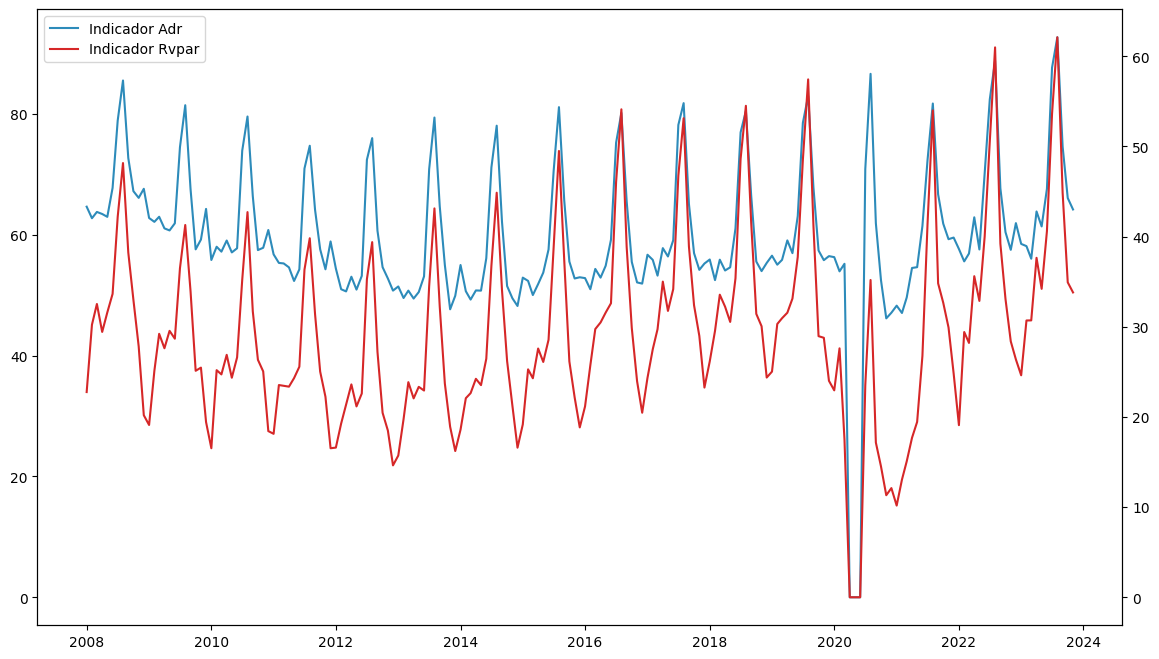

In [13]:
### Desglosamos los pasos para crear el gráfico:

# Creamos figura y eje
fig, ax1 = plt.subplots(figsize=(14,8))

# Configuramos el eje x para el tiempo (index)
ax1.set_xlabel('')
ax1.set_ylabel('', color='#2d8bba') # estoy usando la misma paleta de colores que en la presentación de CANVA

# Graficamos "Indicador Adr" en el primer eje y
line1 = ax1.plot(df.index, df['Indicador Adr'], label='Indicador Adr', color='#2d8bba')

# Segundo eje y que comparte el mismo eje x
ax2 = ax1.twinx()  
ax2.set_ylabel('', color='tab:red')  

# Graficamos "Indicador Rvpar" en el segundo eje y
line2 = ax2.plot(df.index, df['Indicador Rvpar'], label='Indicador Rvpar', color='tab:red')

# ponemos leyendas combinadas (esto no es necesario)
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.savefig("../docs/historico_adr_rvpar.svg", dpi=300) # guardamos gráfico para mostrarlo después en la presentación
plt.show()


<div style="background-color:#2d8bba; color:white; font-weight:bold; padding:10px; border-radius: 5px;">
2 - ANÁLISIS PREDICTIVO
</div>

<div style="background-color:#2d8bba; color:white; font-weight:normal; padding:10px; border-radius: 5px;">
2.1 - Indicador ADR
</div>

In [14]:
### Vamos a emplear una red neuronal recomendada que rinde muy bien para series temporales.
### se llama neuralforecast

# en su github ponen este código de ejemplo:

# from neuralforecast import NeuralForecast
# from neuralforecast.models import NBEATS
# from neuralforecast.utils import AirPassengersDF (este es el dataframe de ejemplo)

# nf = NeuralForecast(
#     models = [NBEATS(input_size=24, h=12, max_steps=100)],
#     freq = 'M'
# )

# nf.fit(df=AirPassengersDF)
# nf.predict()

# vamos a emplearlo y ajustarlo para nuestro código

<div style="background-color:#2d8bba; color:white; font-weight:normal; padding:10px; border-radius: 5px;">
2.1.1. - NeuralForecast
</div>

In [15]:
### importamos las librerías necesarias
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS

In [16]:
# primero preparamos el dataframe (lo llamaré d0) según instrucciones de NF
# reseteamos el index
d0 = df.reset_index()

In [17]:
d0.head()

,index,Indicador Adr,Tasa Variacion Adr,Indicador Rvpar,Tasa Variacion Rvpar
0,2008-01-01,64.63,0.0,22.76,0.0
1,2008-02-01,62.72,0.0,30.23,0.0
2,2008-03-01,63.76,0.0,32.53,0.0
3,2008-04-01,63.42,0.0,29.43,0.0
4,2008-05-01,62.95,0.0,31.59,0.0


In [18]:
# Ahora, 'd0' tiene una columna adicional al principio que representa el índice de tiempo anterior (FECHA)
# Renombramos las columnas adecuadamente: 'ds' para el tiempo y 'y' para 'Indicador Adr'
d0.rename(columns={'index': 'ds', 'Indicador Adr': 'y'}, inplace=True)

In [19]:
# nos tenemos que asegurar de que solo estén las columnas ds, y, dropeamos en resto
d0 = d0.drop(columns=['Tasa Variacion Adr', 'Indicador Rvpar', 'Tasa Variacion Rvpar'])

In [ ]:
# # pasar solo estas dos columnas a NeuralForecast
# d0[['ds', 'y']]

In [20]:
# ha salido un error en la predicción de que faltaba la columna 'unique_id', la creamos como corresponde
# la columna 'unique_id' identifica la serie temporal
d0['unique_id'] = 'Indicador_Adr_Serie'

In [21]:
d0.info

<bound method DataFrame.info of             ds      y            unique_id
0   2008-01-01  64.63  Indicador_Adr_Serie
1   2008-02-01  62.72  Indicador_Adr_Serie
2   2008-03-01  63.76  Indicador_Adr_Serie
3   2008-04-01  63.42  Indicador_Adr_Serie
4   2008-05-01  62.95  Indicador_Adr_Serie
..         ...    ...                  ...
186 2023-07-01  87.64  Indicador_Adr_Serie
187 2023-08-01  92.66  Indicador_Adr_Serie
188 2023-09-01  74.58  Indicador_Adr_Serie
189 2023-10-01  66.06  Indicador_Adr_Serie
190 2023-11-01  64.17  Indicador_Adr_Serie

[191 rows x 3 columns]>

In [22]:
# El índice de 'd0' ya está en formato datetime y es mensual ('M')
# NeuralForecast espera una columna 'ds' para la fecha y 'y' para los valores

nf = NeuralForecast(
    models = [NBEATS(input_size=24, h=12, max_steps=100)],  # Ajustados estos para la predicción de 12 meses
    freq = 'M'  # Frecuencia mensual
)

# para que esté en el formato esperado por NeuralForecast
nf.fit(df=d0)
predictions = nf.predict() # el dataframe 'predictions' contendrá las predicciones para los próximos 12 meses


Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [23]:
# parece que todo ha ido OK, vamos a graficar los resultados
# antes de esto, veamos qué tipo de datos devuelve 'predictions' 
predictions.head()

,ds,NBEATS
unique_id,,
Indicador_Adr_Serie,2023-11-30,64.847023
Indicador_Adr_Serie,2023-12-31,62.387688
Indicador_Adr_Serie,2024-01-31,60.046680
Indicador_Adr_Serie,2024-02-29,62.358810
Indicador_Adr_Serie,2024-03-31,63.400951


In [24]:
d0.head()

,ds,y,unique_id
0,2008-01-01,64.63,Indicador_Adr_Serie
1,2008-02-01,62.72,Indicador_Adr_Serie
2,2008-03-01,63.76,Indicador_Adr_Serie
3,2008-04-01,63.42,Indicador_Adr_Serie
4,2008-05-01,62.95,Indicador_Adr_Serie


In [ ]:
# ahora hay que asegurarse de que para concatenar ambas series temporales, tanto el índice de los dataframes d0 y predictions
# están con fecha y en formato datetime, de lo contrario la serie temporal no saldrá gráficamente. 
# primero vamos a asegurarnos de que ambas columnas de los dataframes están en formato datetime

In [25]:
d0.dtypes

ds           datetime64[ns]
y                   float64
unique_id            object
dtype: object

In [26]:
predictions.dtypes

ds        datetime64[ns]
NBEATS           float64
dtype: object

In [ ]:
# vemos que sí están "ds" en datetime. pasamos al index en ambos dataframes

In [27]:
d0.set_index('ds', inplace=True)

In [28]:
predictions.set_index('ds', inplace=True)

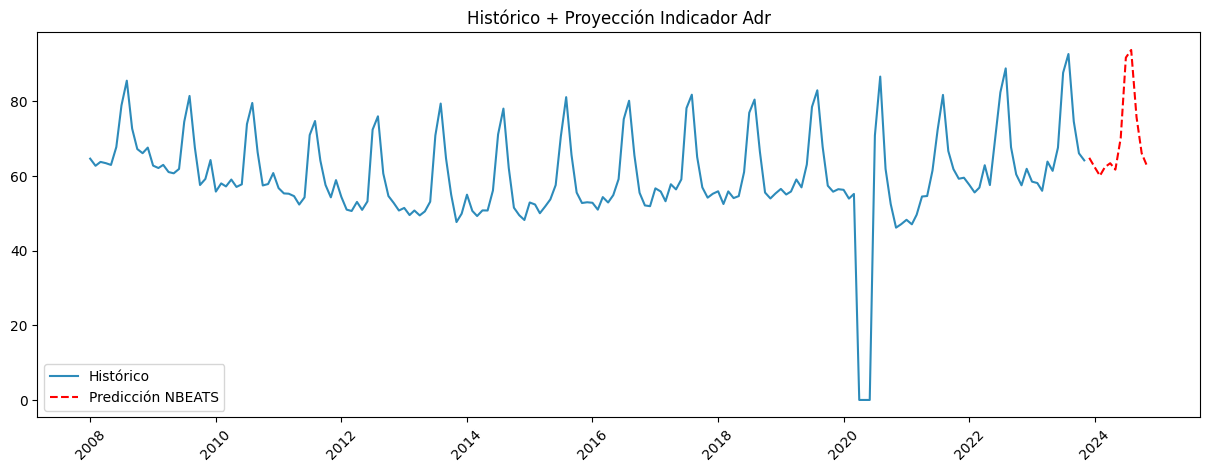

In [29]:
# Graficamos histórico + predicción

plt.figure(figsize=(15, 5))
plt.plot(d0.index, d0['y'], label='Histórico', color='#2d8bba')
plt.plot(predictions.index, predictions['NBEATS'], label='Predicción NBEATS', linestyle='--', color='red')
plt.title('Histórico + Proyección Indicador Adr')
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.savefig("../docs/historico_y_proyeccion_indicadoradr.svg", dpi=300)
plt.show()

In [ ]:
# podemos comprobar como, a priori, el modelo es efectivo a 12 meses vista

<div style="background-color:#2d8bba; color:white; font-weight:normal; padding:10px; border-radius: 5px;">
2.1.2. - Prophet
</div>

In [30]:
### probaremos ahora el modelo de Facebook Prophet, que es muy popular y efectivo para series temporales
### importamos 
from prophet import Prophet

In [31]:
# recordemos la estructura de 'd0'
d0

,y,unique_id
ds,,
2008-01-01,64.63,Indicador_Adr_Serie
2008-02-01,62.72,Indicador_Adr_Serie
2008-03-01,63.76,Indicador_Adr_Serie
2008-04-01,63.42,Indicador_Adr_Serie
2008-05-01,62.95,Indicador_Adr_Serie
...,...,...
2023-07-01,87.64,Indicador_Adr_Serie
2023-08-01,92.66,Indicador_Adr_Serie
2023-09-01,74.58,Indicador_Adr_Serie


In [32]:
# vamos a crear un df que cumpla con los requisitos de Prophet, en nuestro caso dropeamos la columna 'unique_id'
# aprovecharemos también para renombrarlo y usarlo en este ejercicio
d1 = d0.drop(columns='unique_id')

In [33]:
# reseteamos el index
d1 = d1.reset_index()

In [34]:
# comenzamos el modelo Prophet
m = Prophet()

# ajustamos con nuestros datos
m.fit(d1)

# esto crea un DataFrame para las predicciones futuras
future = m.make_future_dataframe(periods=12, freq='M')  # ajustamos el número de períodos según necesidad

# usamos el anterior para la predicción
forecast = m.predict(future)

# forecast es un DataFrame que contiene la predicción y componentes como tendencia y estacionalidad


16:56:31 - cmdstanpy - INFO - Chain [1] start processing
16:56:31 - cmdstanpy - INFO - Chain [1] done processing


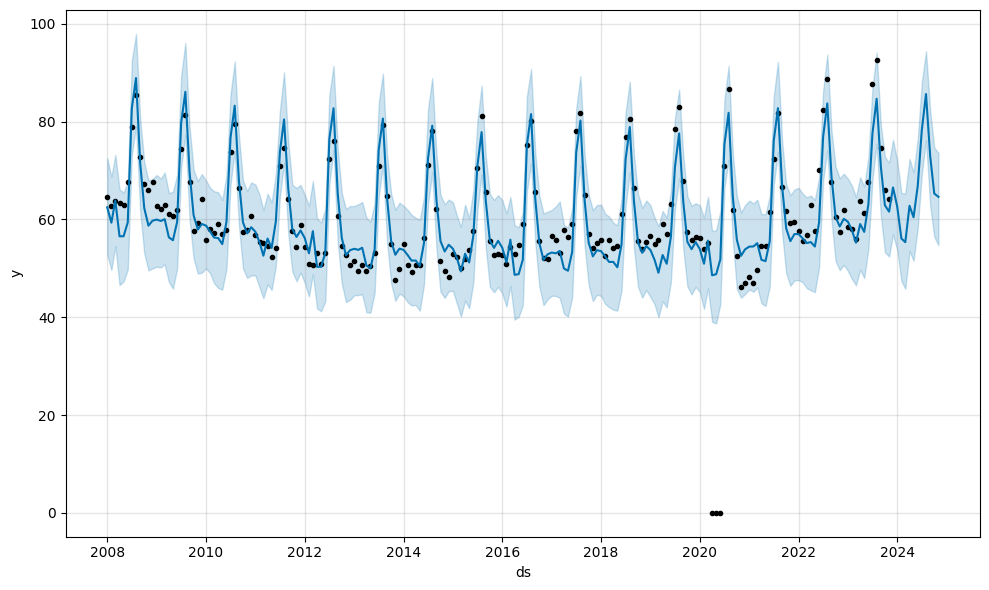

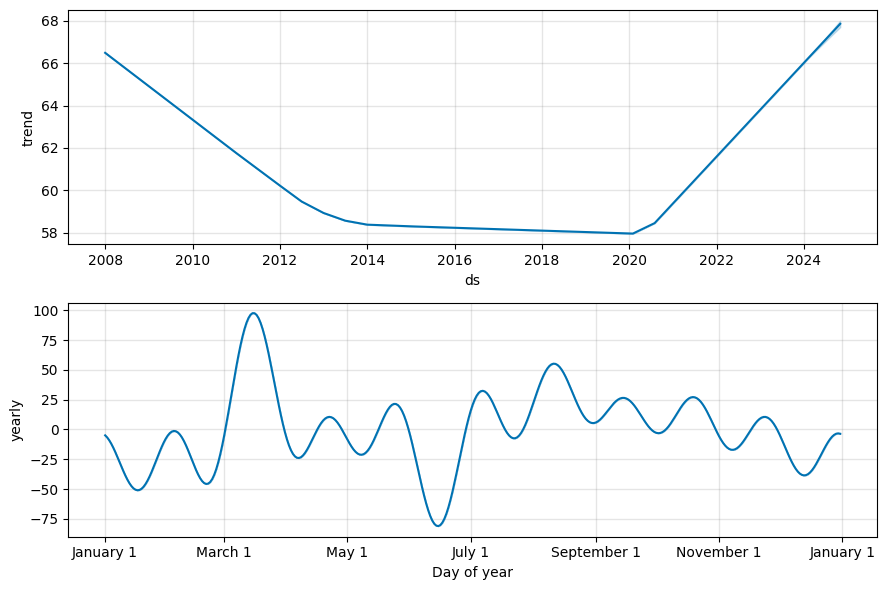

In [35]:
# reseñable el poco tiempo que ha tardado en realizar la predicción, es muy rápido
# prophet tiene una manera de graficar predicciones y componentes propia:

from prophet.plot import plot

# Plot de las predicciones
fig1 = m.plot(forecast)
plt.savefig("../docs/prophet_predicciones.svg", dpi=300)
plt.show()

# Plot de los componentes de la predicción (tendencia, estacionalidad)
fig2 = m.plot_components(forecast)
plt.savefig("../docs/prophet_componentes.svg", dpi=300)
plt.show()

In [ ]:
# como podemos ver, el modelo prophet combina tendencia y estacionalidad para realizar las proyecciones. 
# en el gráfico "trend" vemos claramente la evolución de la tendencia y cómo a partir del covid es claramente ascendente. 

In [36]:
### preparamos los datos para el entrenamiento de prophet
d1.set_index('ds', inplace=True)
d1.index = pd.to_datetime(d1.index)


In [37]:
### ahora vamos a dividir los datos en entrenamiento y test
# vamos a establecer como fecha de corte el 1 de enero de 2021
split_date = '2021-01-01'
d1_train = d1.loc[d1.index <= split_date].copy()    # datos de entrenamiento
d1_test = d1.loc[d1.index > split_date].copy()      # datos de test


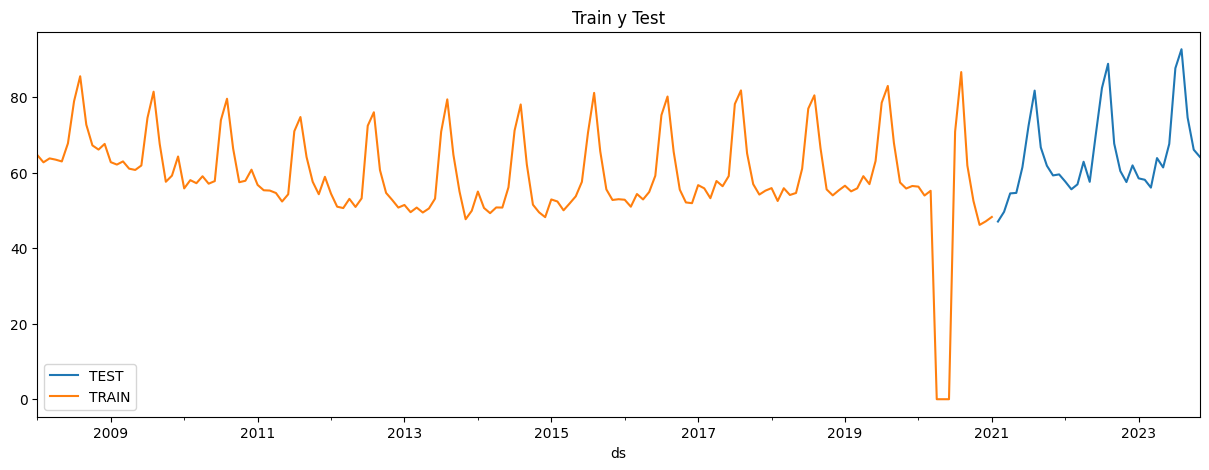

In [38]:
### vamos a graficar train y test para ver dónde se produce el corte
d1_test \
    .rename(columns={'y': 'TEST'}) \
    .join(d1_train.rename(columns={'y': 'TRAIN'}), how='outer') \
    .plot(figsize=(15,5), title='Train y Test', style='-', ms=10) 

plt.show()

In [39]:
d1_train_prophet = d1_train.reset_index() # vamos a emplear este dataframe y reseteamos el index para que prophet pueda leerlo 

In [40]:
# Ajustamos el modelo Prophet con los datos de entrenamiento
m = Prophet()
m.fit(d1_train_prophet)

17:08:19 - cmdstanpy - INFO - Chain [1] start processing
17:08:20 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
d1_test_prophet = d1_test.reset_index() # reseteamos el index también

In [42]:
d1_test_forecast = m.predict(d1_test_prophet)   # predecimos con los datos de test

In [43]:
d1_test_forecast.head(1) # vemos cómo ha quedado el dataframe de predicciones

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-01,54.313036,40.811988,60.563124,54.313036,54.313049,-3.472139,-3.472139,-3.472139,-3.472139,-3.472139,-3.472139,0.0,0.0,0.0,50.840897


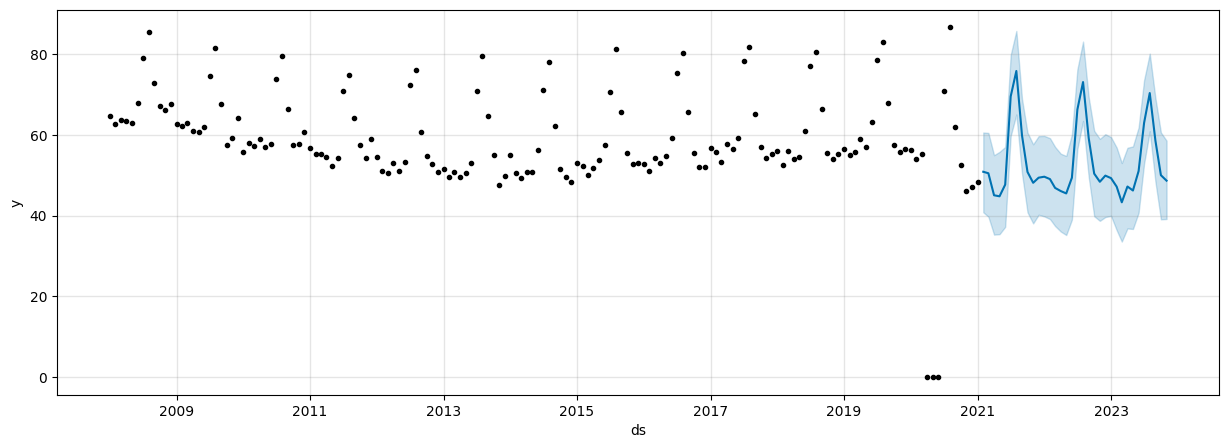

In [44]:
fig, ax = plt.subplots(figsize=(15, 5))
fig = m.plot(d1_test_forecast, ax=ax) # el punto es para ver mejor los datos

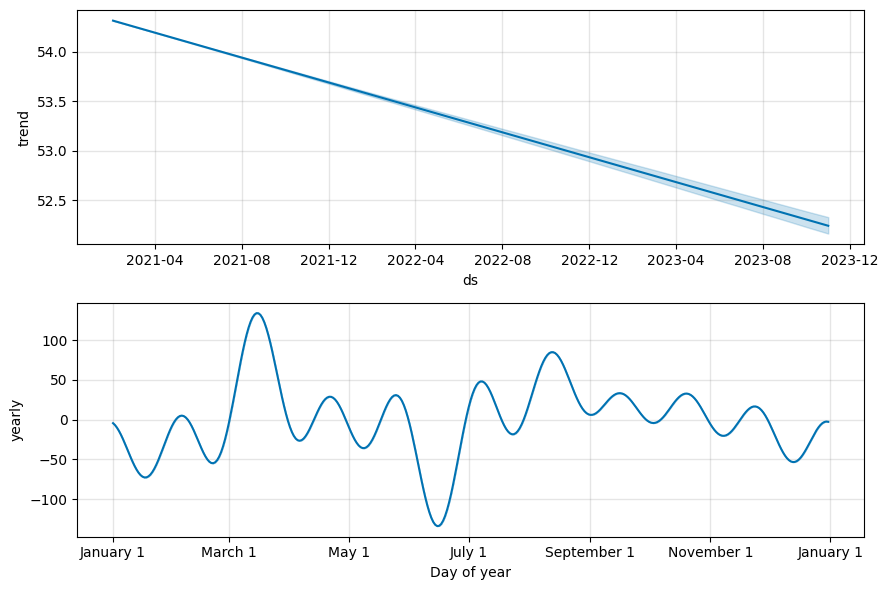

In [45]:
### vamos a graficar los componentes de la predicción
fig = m.plot_components(d1_test_forecast)
plt.show()

In [46]:
d1_test_prophet.set_index('ds', inplace=True) # pasamos el index a datetime

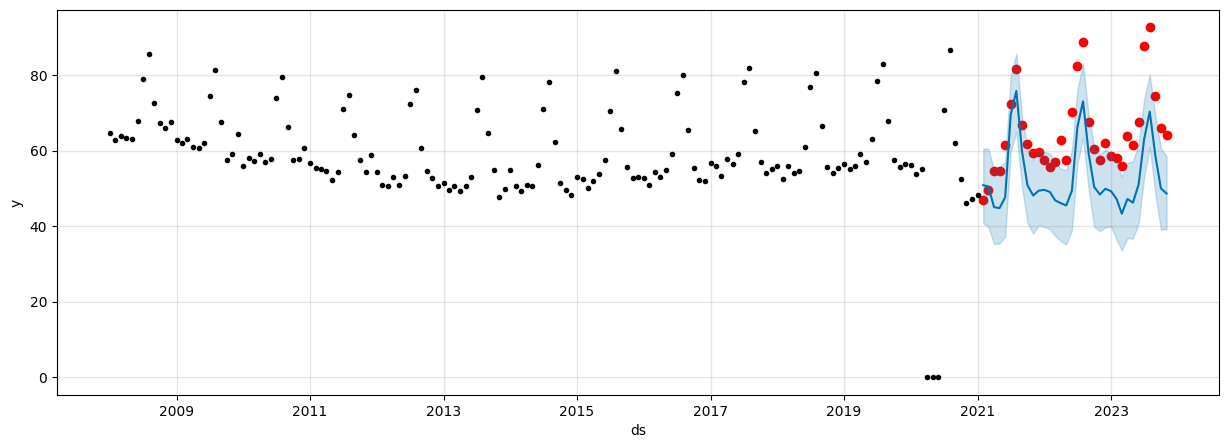

In [47]:
### comparamos las predicciones con los datos reales

fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(d1_test_prophet.index, d1_test_prophet['y'], color='r')
fig = m.plot(d1_test_forecast, ax=ax)

In [48]:
### evaluamos el modelo con métricas de error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


In [49]:
# Calculamos el error cuadrático medio:
mse = mean_squared_error(y_true=d1_test_prophet['y'], y_pred=d1_test_forecast['yhat'])
print(mse)

171.28800513482008


In [50]:
mae = mean_absolute_error(y_true=d1_test_prophet['y'], y_pred=d1_test_forecast['yhat'])
print(mae)

11.986861769812727


<div style="background-color:#2d8bba; color:white; font-weight:normal; padding:10px; border-radius: 5px;">
Conclusiones de modelo Prophet: aunque capta bien las tendencias, el modelo se ve afectado por la pandemia y habrá que corregirlo ajustando este período
</div>

In [51]:
### en el modelo prophet, se puede añadir eventos como "holidays" para mejorar la predicción.
### vamos a añadir el covid como evento, ya que ha sido un punto de inflexión en la serie temporal, en forma de dataframe:

pandemia = pd.DataFrame({'holiday': 'pandemia','ds': pd.to_datetime(['2020-03-01', '2020-04-01', '2020-05-01']),
  'lower_window': 0,
  'upper_window': 1,
})


In [52]:
pandemia.head(1)

,holiday,ds,lower_window,upper_window
0,pandemia,2020-03-01,0,1


In [53]:
### ajustamos el modelo con el evento
model = Prophet(holidays=pandemia)
model.fit(d1_train_prophet)

17:11:33 - cmdstanpy - INFO - Chain [1] start processing
17:11:33 - cmdstanpy - INFO - Chain [1] done processing


In [54]:
d1_test_prophet = d1_test.reset_index() # reseteamos el index para que prophet pueda leerlo

In [55]:
d1_test_forecast = model.predict(d1_test_prophet)  # predecimos con los datos de test

In [56]:
d1_test_forecast.head(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,pandemia,pandemia_lower,pandemia_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-01,59.165538,44.686148,60.605732,59.165538,59.165538,-6.964947,-6.964947,-6.964947,0.0,...,0.0,0.0,0.0,-6.964947,-6.964947,-6.964947,0.0,0.0,0.0,52.200591


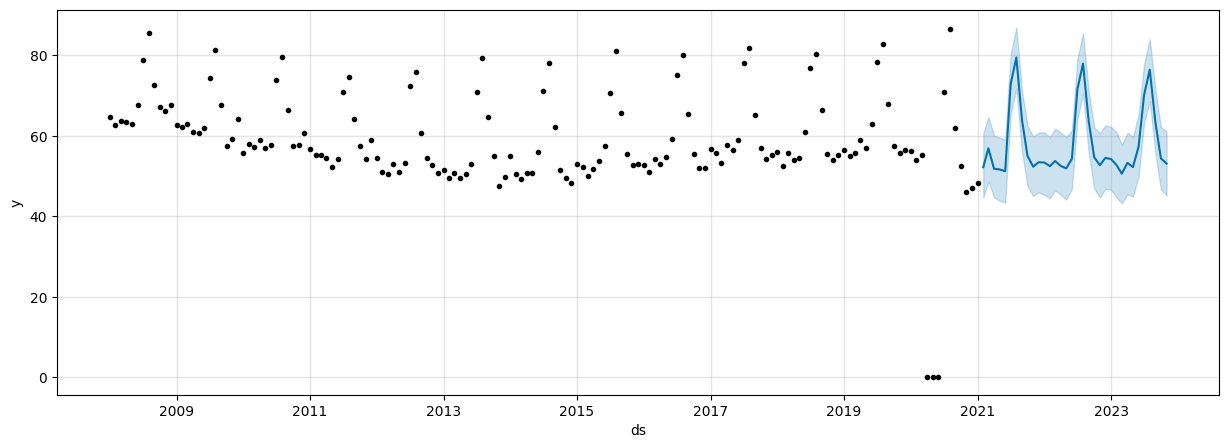

In [58]:
# graficamos el histórico con el entrenamiento
fig, ax = plt.subplots(figsize=(15, 5))
fig = model.plot(d1_test_forecast, ax=ax) # el punto es para ver mejor los datos

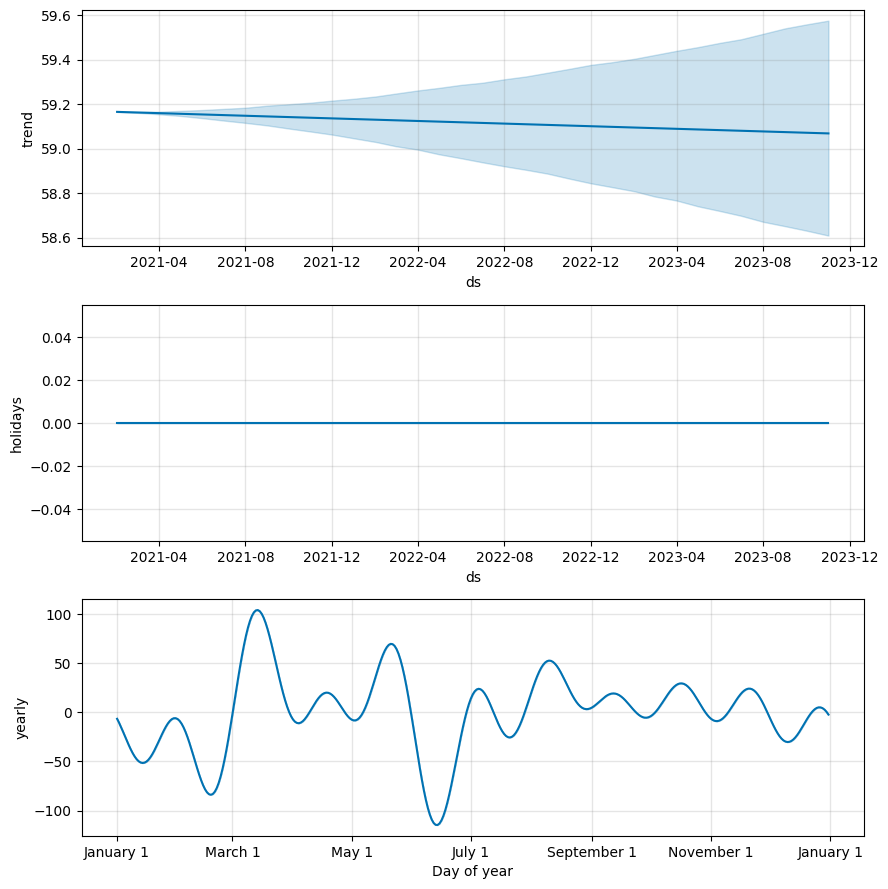

In [59]:
### vamos a graficar los componentes de la predicción
fig = model.plot_components(d1_test_forecast)
plt.show()

In [ ]:
### Se puede observar cómo los componentes han cambiado con la inclusión del evento "pandemia".

In [60]:
# preparamos el test para la evaluación
d1_test_prophet.set_index('ds', inplace=True)

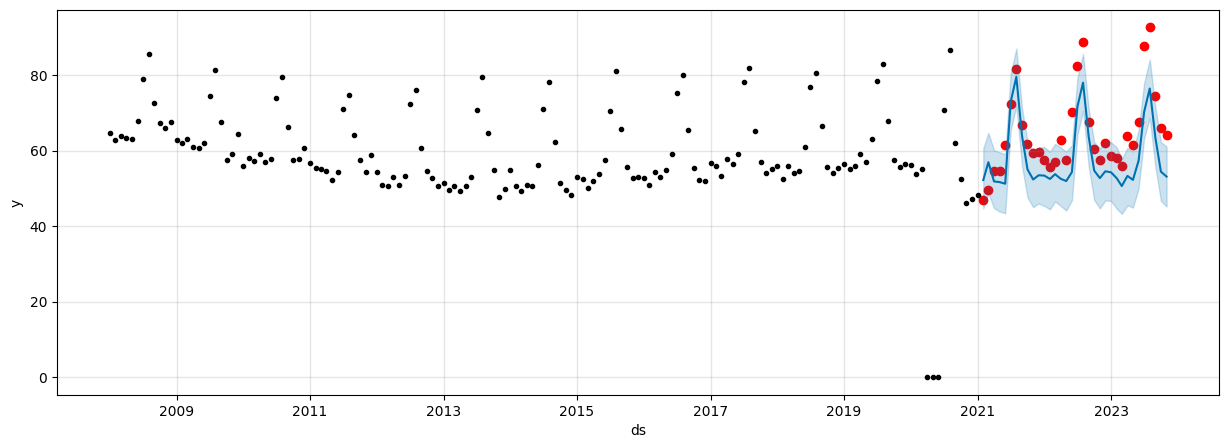

In [61]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(d1_test_prophet.index, d1_test_prophet['y'], color='r')
fig = model.plot(d1_test_forecast, ax=ax)

In [62]:
### veamos ahora las métricas de error para ver si el modelo ha mejorado

In [63]:
# Calculamos el error cuadrático medio:
mse = mean_squared_error(y_true=d1_test_prophet['y'], y_pred=d1_test_forecast['yhat'])
print(mse)

72.30312492948727


In [64]:
mae = mean_absolute_error(y_true=d1_test_prophet['y'], y_pred=d1_test_forecast['yhat'])
print(mae)

7.408622835656965


In [ ]:
### vamos a medir de manera porcentual el error, definiendo mape y smape

In [65]:
def smape(y_true, y_pred):
    """ Función para calcular el error porcentual medio absoluto simétrico """
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # para evitar división por cero
    return np.mean(diff) * 100

In [66]:
def mape(y_true, y_pred):
    """ Función para calcular el error porcentual medio absoluto """
    diff = np.abs((y_true - y_pred) / y_true)
    diff[y_true == 0] = 0.0  # para evitar división por cero
    return np.mean(diff) * 100

In [67]:
d1_test_forecast.set_index('ds', inplace=True)


In [68]:
smape_value = smape(y_true=d1_test_prophet['y'], y_pred=d1_test_forecast['yhat'])
mape_value = mape(y_true=d1_test_prophet['y'], y_pred=d1_test_forecast['yhat'])


In [69]:
print(f"El sMAPE es: {smape_value}")
print(f"El MAPE es: {mape_value}")

El sMAPE es: 11.939650051705772
El MAPE es: 11.212349880668178


<div style="background-color:#2d8bba; color:white; font-weight:normal; padding:10px; border-radius: 5px;">
Se puede observar la mejora muy significativa de introducir el parámetro "HOLIDAYS" en el modelo Prophet. El error de 7.40 en el Mean Absolute Error, menor del 10% de la escala total, puede ser aceptable para nuestras predicciones.
</div>

In [70]:
### ahora vamos a entrenar el modelo con el dataset completo y a predecir los próximos 12 meses
### de igual modo que antes, reseteamos el index para que prophet pueda leerlo
d1.reset_index(inplace=True)

model = Prophet(holidays=pandemia)
model.fit(d1)

17:18:08 - cmdstanpy - INFO - Chain [1] start processing
17:18:08 - cmdstanpy - INFO - Chain [1] done processing


In [71]:
# esto crea un DataFrame para las predicciones futuras
future = model.make_future_dataframe(periods=12, freq='M')  # ajustamos el número de períodos según necesidad

# usamos el anterior para la predicción
forecast = model.predict(future)

In [72]:
# vamos a graficar las predicciones
from prophet.plot import add_changepoints_to_plot # esta función nos permite ver los puntos de inflexión  

In [73]:
forecast.head(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,pandemia,pandemia_lower,pandemia_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-01-01,68.122335,55.890699,70.988608,68.122335,68.122335,-4.716214,-4.716214,-4.716214,0.0,...,0.0,0.0,0.0,-4.716214,-4.716214,-4.716214,0.0,0.0,0.0,63.40612


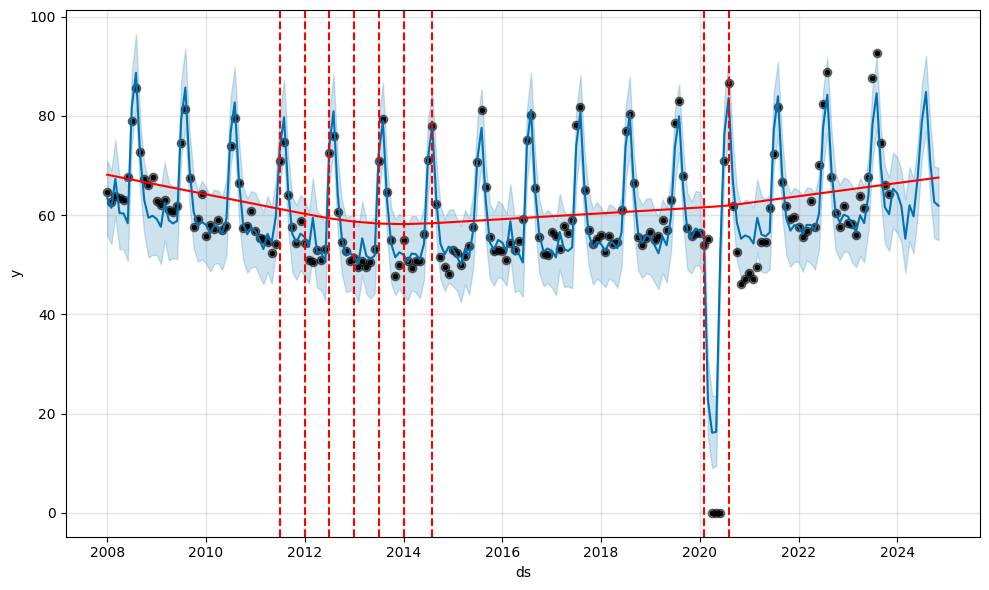

In [74]:
### no olvidemos que ahora el modelo es "model" en lugar de "m" como antes
fig1 = model.plot(forecast)

### esta línea es opcional, pero añade los puntos de cambio en la tendencia
a = add_changepoints_to_plot(fig1.gca(), model, forecast)

# Añadimos el histórico con puntos negros
plt.scatter(d1['ds'], d1['y'], color='black', marker='o', alpha=0.5)

plt.savefig('../docs/prophet_prediction_with_holidays.svg', dpi=300)
plt.show()

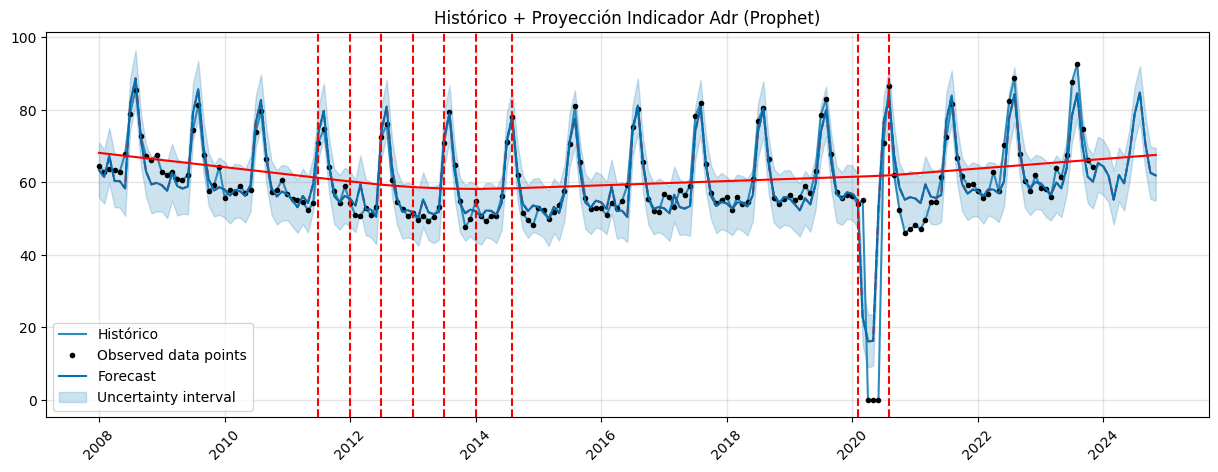

In [76]:
### vamos a graficarlo ahora con matplotlib

plt.figure(figsize=(15, 5))

# graficamos histórico
plt.plot(d1['ds'], d1['y'], label='Histórico', color='#2d8bba')

# Grafica las predicciones de Prophet
# Asume que 'forecast' tiene una columna 'ds' para las fechas y una columna 'yhat' para las predicciones
plt.plot(forecast['ds'], forecast['yhat'], linestyle='--', color='red')

fig1 = model.plot(forecast, ax=plt.gca())  # Esto crea el gráfico de Prophet en el eje actual de matplotlib
add_changepoints_to_plot(fig1.gca(), model, forecast)

# títulos y etiquetas
plt.title('Histórico + Proyección Indicador Adr (Prophet)')
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('')

plt.legend()
plt.savefig("../docs/historico_y_proyeccion_indicadoradr.svg", dpi=300)
plt.show()


<div style="background-color:#2d8bba; color:white; font-weight:normal; padding:10px; border-radius: 5px;">
2.1.3. - XGBoost
</div>

In [ ]:
# vamos a predecir ahora con xgboost

In [79]:
import xgboost as xgb   
from sklearn.model_selection import train_test_split    # para dividir los datos en entrenamiento y test

In [ ]:
### tenemos que preparar los datos para xgboost. esto se hace dema nera diferente a prophet y neuralforecast.

In [81]:
d0.reset_index(inplace=True) # reseteamos el index para que xgboost pueda leerlo

In [90]:
# Añadimos características de fecha
d0['year'] = d0['ds'].dt.year
d0['month'] = d0['ds'].dt.month
### d0['day'] = d0['ds'].dt.day # esto es opcional, si en nuestro caso no hay días, no es necesario

# la columna 'unique_id' no será utilizado como característica
X = d0[['year', 'month']]  # Añade más características según sea necesario
y = d0['y'] # la variable objetivo     

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45) # dividimos los datos en entrenamiento y test

In [92]:
dtrain = xgb.DMatrix(X_train, label=y_train) # creamos un DMatrix para xgboost
dtest = xgb.DMatrix(X_test, label=y_test) # igual para test

In [93]:
# definimos los parámetros del modelo
params = {
    'objective': 'reg:squarederror',    # función de pérdida para regresión
    'max_depth': 5,                     # profundidad máxima del árbol
    'eta': 0.1,                         # tasa de aprendizaje
    'eval_metric': 'rmse'               # métrica de evaluación, en este caso el error cuadrático medio
}
num_boost_round = 100                   # número de iteraciones

bst = xgb.train(params, dtrain, num_boost_round, [(dtest, 'eval')], early_stopping_rounds=10) # entrenamos el modelo


[0]	eval-rmse:8.43717
[1]	eval-rmse:7.79372
[2]	eval-rmse:7.21916
[3]	eval-rmse:6.70746
[4]	eval-rmse:6.25648
[5]	eval-rmse:5.85638
[6]	eval-rmse:5.49820
[7]	eval-rmse:5.10031
[8]	eval-rmse:4.75867
[9]	eval-rmse:4.43559
[10]	eval-rmse:4.15007
[11]	eval-rmse:3.98274
[12]	eval-rmse:3.82303
[13]	eval-rmse:3.68623
[14]	eval-rmse:3.54866
[15]	eval-rmse:3.43219
[16]	eval-rmse:3.32480
[17]	eval-rmse:3.17774
[18]	eval-rmse:3.04747
[19]	eval-rmse:3.00139
[20]	eval-rmse:2.88105
[21]	eval-rmse:2.78184
[22]	eval-rmse:2.66896
[23]	eval-rmse:2.61099
[24]	eval-rmse:2.54587
[25]	eval-rmse:2.57816
[26]	eval-rmse:2.61499
[27]	eval-rmse:2.60292
[28]	eval-rmse:2.53419
[29]	eval-rmse:2.51257
[30]	eval-rmse:2.44656
[31]	eval-rmse:2.40051
[32]	eval-rmse:2.36090
[33]	eval-rmse:2.32126
[34]	eval-rmse:2.29833
[35]	eval-rmse:2.27475
[36]	eval-rmse:2.25392
[37]	eval-rmse:2.22520
[38]	eval-rmse:2.17400
[39]	eval-rmse:2.15398
[40]	eval-rmse:2.12247
[41]	eval-rmse:2.09630
[42]	eval-rmse:2.06511
[43]	eval-rmse:2.0429

In [94]:
predictions = bst.predict(dtest)    # hacemos las predicciones

In [95]:
rmse = mean_squared_error(y_test, predictions, squared=False) # calculamos el error cuadrático medio
print(f"RMSE: {rmse}")

RMSE: 1.8910732720832775


In [ ]:
### El valor cuadrático medio es de 1.89, lo que indica que el modelo es efectivo
# vamos a graficar las predicciones pero primero vamos a preparar los datos para ello, entre ellos el modelo.

In [96]:
# última fecha en el conjunto de datos
last_month = pd.to_datetime('2023-11')

# Generamos una lista de fechas para los próximos 12 meses
future_months = pd.date_range(start=last_month, periods=13, freq='M')[1:]  # [1:] para excluir el último mes de los datos originales

# Creamos future_df
future_df = pd.DataFrame({
    'year': future_months.year,
    'month': future_months.month
})

In [97]:
X_future = future_df  # este ya contiene solo las características necesarias
future_dmatrix = xgb.DMatrix(X_future) # creamos un DMatrix para xgboost
future_predictions = bst.predict(future_dmatrix) # hacemos las predicciones

In [100]:
future_df['y_pred'] = future_predictions  # añadimos las predicciones al dataframe

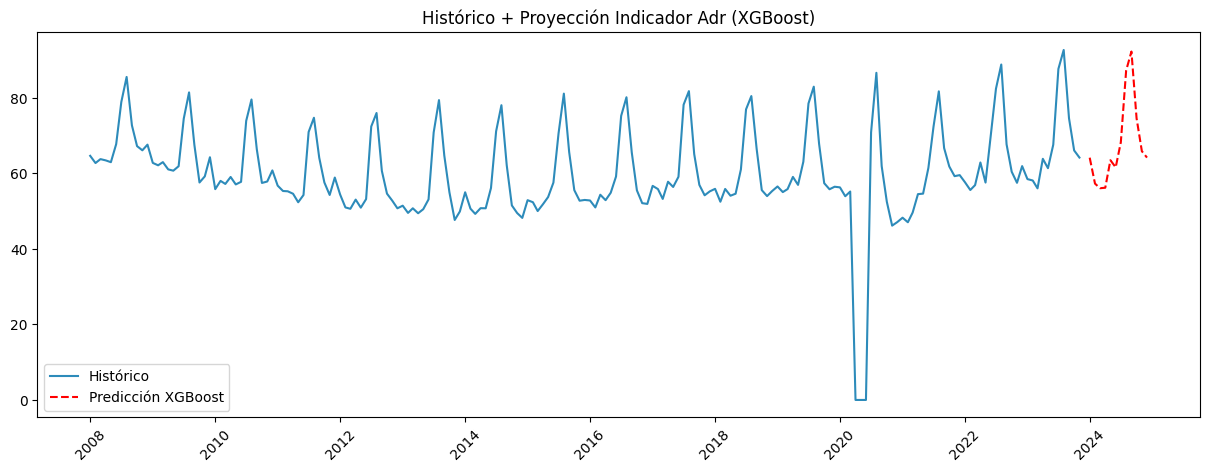

In [104]:
plt.figure(figsize=(15, 5))
plt.plot(d1['ds'], d1['y'], label='Histórico', color='#2d8bba')
plt.plot(future_months, future_predictions, linestyle='--', color='red', label='Predicción XGBoost')

plt.title('Histórico + Proyección Indicador Adr (XGBoost)')
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.savefig("../docs/historico_y_proyeccion_indicadoradr_xgboost.svg", dpi=300)
plt.show()

<div style="background-color:#2d8bba; color:white; font-weight:normal; padding:10px; border-radius: 5px;">
2.2 - PARÁMETRO REVPAR
</div>

<div style="background-color:#2d8bba; color:white; font-weight:normal; padding:10px; border-radius: 5px;">
2.2.1 - XGBoost
</div>

In [ ]:
### Esta vez volvemos al dataset original, que contiene las dos columnas de interés, 'Indicador Adr' e 'Indicador Rvpar'
### vamos a predecir con xgboost el 'Indicador Rvpar'. Empezamos con la preparación de los datos

In [159]:
df.head(1)

2008-01-01    22.76
Freq: MS, Name: Indicador Rvpar, dtype: float64

In [130]:
df = df['Indicador Rvpar']  # seleccionamos la columna 'Indicador Rvpar'

In [131]:
dx = df.to_frame(name='y')  # convertimos la serie temporal en dataframe  (y de paso renombramos la columna)

In [132]:
dx.reset_index(inplace=True) # reseteamos el index para que xgboost pueda leerlo

In [135]:
dx.rename(columns={'index': 'ds'}, inplace=True) # renombramos la columna 'FECHA' a 'ds'

In [137]:
dx['year'] = dx['ds'].dt.year # añadimos características de fecha (año en este caso)
dx['month'] = dx['ds'].dt.month # añadimos características de fecha (mes)
# ahora dx es un dataframe con las columnas ds, year, month, y y.

In [138]:
# preparación de los datos para entrenamiento y test, con el año y mes como características e 'y' como variable objetivo
X = dx[['year', 'month']]
y = dx['y']

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45) # dividimos los datos en entrenamiento y test

In [140]:
dtrain = xgb.DMatrix(X_train, label=y_train)    # creamos un DMatrix para xgboost
dtest = xgb.DMatrix(X_test, label=y_test)       # igual para test

In [155]:
# definimos los parámetros del modelo
params = {
    'objective': 'reg:squarederror',    # función de pérdida para regresión
    'max_depth': 3,                     # profundidad máxima del árbol
    'eta': 0.5,                         # tasa de aprendizaje
    'eval_metric': 'rmse'               # métrica de evaluación, en este caso el error cuadrático medio
}

num_boost_round = 100                  # número de iteraciones

In [156]:
bst = xgb.train(params, dtrain, num_boost_round, [(dtest, 'test')], early_stopping_rounds=10) # entrenamos el modelo

[0]	test-rmse:7.80040
[1]	test-rmse:6.68537
[2]	test-rmse:5.85513
[3]	test-rmse:5.03594
[4]	test-rmse:4.29315
[5]	test-rmse:4.22734
[6]	test-rmse:4.07932
[7]	test-rmse:3.73618
[8]	test-rmse:3.30102
[9]	test-rmse:3.11133
[10]	test-rmse:3.11749
[11]	test-rmse:2.89072
[12]	test-rmse:2.84319
[13]	test-rmse:2.85248
[14]	test-rmse:2.69686
[15]	test-rmse:2.70497
[16]	test-rmse:2.53454
[17]	test-rmse:2.53999
[18]	test-rmse:2.48420
[19]	test-rmse:2.43397
[20]	test-rmse:2.39533
[21]	test-rmse:2.40233
[22]	test-rmse:2.42577
[23]	test-rmse:2.45730
[24]	test-rmse:2.38097
[25]	test-rmse:2.36938
[26]	test-rmse:2.30154
[27]	test-rmse:2.26681
[28]	test-rmse:2.27660
[29]	test-rmse:2.27559
[30]	test-rmse:2.25430
[31]	test-rmse:2.20649
[32]	test-rmse:2.20869
[33]	test-rmse:2.16434
[34]	test-rmse:2.12944
[35]	test-rmse:2.16133
[36]	test-rmse:2.12675
[37]	test-rmse:2.12757
[38]	test-rmse:2.13113
[39]	test-rmse:2.09885
[40]	test-rmse:2.09511
[41]	test-rmse:2.09504
[42]	test-rmse:2.11275
[43]	test-rmse:2.0912

In [157]:
predictions = bst.predict(dtest) # hacemos las predicciones

In [158]:
# calculamos el error cuadrático medio
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f"RMSE: {rmse}")

RMSE: 2.0608952883760367


In [ ]:
### El valor cuadrático medioes 2.06, lo que indica que el modelo es efectivo
### a graficar las predicciones

In [163]:
# antes,tenemos que preparar el rango de fechas para los próximos 12 meses
last_date = dx['ds'].max() # última fecha en el conjunto de datos
future_months = pd.date_range(start=last_date, periods=13, freq='M')[1:]  # [1:] para excluir el último mes de los datos originales

In [164]:
future_df = pd.DataFrame(future_predictions, columns=['y_pred'])
future_df['ds'] = future_months


In [165]:
### nos queda crear el dataframe de las fechas futuras y hacer las predicciones
future_X = pd.DataFrame({
    'year': future_months.year,
    'month': future_months.month
})

In [166]:
# Convertimos a DMatrix
future_dmatrix = xgb.DMatrix(future_X)

In [167]:
# Generamos predicciones para las fechas futuras
future_predictions = bst.predict(future_dmatrix)

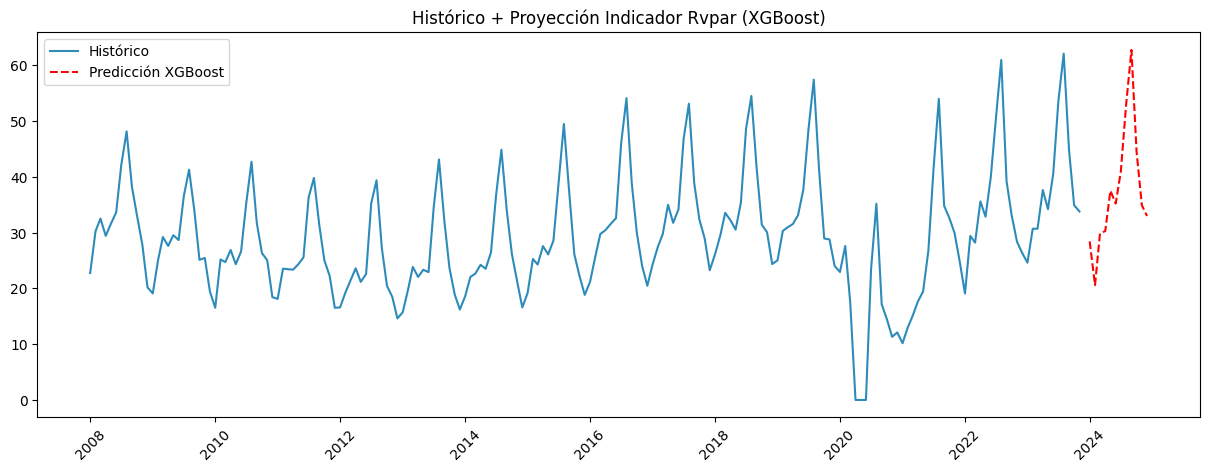

In [168]:
### vamos a graficar las predicciones

plt.figure(figsize=(15, 5))
plt.plot(dx['ds'], dx['y'], label='Histórico', color='#2d8bba')
plt.title('Histórico + Proyección Indicador Rvpar (XGBoost)')
plt.plot(future_months, future_predictions, linestyle='--', color='red', label='Predicción XGBoost')

plt.legend()
plt.xticks(rotation=45)
plt.show()

<div style="background-color:red; color:white"> </div>